# requirement:
    torch
    torchvision
    numpy
    PIL
    matplotlib(to show results)

In [1]:
%reload_ext autoreload
%autoreload 2

import numpy as np
from PIL import Image

import torch
from torchvision import datasets, models, transforms
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F

import matplotlib.pyplot as plt
%matplotlib inline

import sys
sys.path.append("../")
import layers, utils

with open("./imagenet_label_mapping") as f:
        image_label_mapping = {int(x.split(":")[0]): x.split(":")[1].strip()
                               for x in f.readlines() if len(x.strip()) > 0}

# setup the network 

In [2]:
vgg = models.vgg16(pretrained=True)
vgg.cuda()
vgg.eval()

class My_VGG16(nn.Module):
    def __init__(self):
        super(My_VGG16, self).__init__()
        self.layers = nn.Sequential(layers.Conv2d(vgg.features[0]), layers.ReLU(), 
                                    layers.Conv2d(vgg.features[2]), layers.ReLU(), layers.MaxPool2d(vgg.features[4]), 
                                    layers.Conv2d(vgg.features[5]), layers.ReLU(),
                                    layers.Conv2d(vgg.features[7]), layers.ReLU(), layers.MaxPool2d(vgg.features[9]), 
                                    layers.Conv2d(vgg.features[10]), layers.ReLU(), 
                                    layers.Conv2d(vgg.features[12]), layers.ReLU(), 
                                    layers.Conv2d(vgg.features[14]), layers.ReLU(), layers.MaxPool2d(vgg.features[16]), 
                                    layers.Conv2d(vgg.features[17]), layers.ReLU(),
                                    layers.Conv2d(vgg.features[19]), layers.ReLU(), 
                                    layers.Conv2d(vgg.features[21]), layers.ReLU(), layers.MaxPool2d(vgg.features[23]), 
                                    layers.Conv2d(vgg.features[24]), layers.ReLU(), 
                                    layers.Conv2d(vgg.features[26]), layers.ReLU(), 
                                    layers.Conv2d(vgg.features[28]), layers.ReLU(), layers.MaxPool2d(vgg.features[30]), 
                                    layers.Reshape(), 
                                    layers.Linear(vgg.classifier[0]), layers.ReLU(), 
                                    layers.Linear(vgg.classifier[3]), layers.ReLU(),
                                    layers.Linear(vgg.classifier[6])
                                    )
       
    def forward(self, x):
        x = self.layers(x)
        return x
    
    def pattern_LRP(self, R):
        for l in range(len(self.layers), 0, -1):
            R = self.layers[l-1].pattern_LRP(R)
        return R

    
my_vgg = My_VGG16()
my_vgg.cuda()
my_vgg.eval()

My_VGG16(
  (layers): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU()
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU()
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU()
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU()
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU()
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (17): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), 

In [3]:
# load Pattern.
pattern = np.load("./pattern_40000iter.npy")

In [5]:
def forward_hook(self, input, output):
    self.X = input[0]
    self.Y = output

# forward_hook. 
for i in range(len(my_vgg.layers)):
    my_vgg.layers[i].register_forward_hook(forward_hook)

# hook pattern to each layer.
cnt = 0
for layer in my_vgg.layers:
    if layer.__class__.__name__ in ["Linear", "Conv2d"]:
        if layer.__class__.__name__ is "Conv2d":
            layer.A = torch.from_numpy(pattern[cnt]).type(torch.cuda.FloatTensor)
            cnt += 1
        if layer.__class__.__name__ is "Linear":
            layer.A = torch.from_numpy(pattern[cnt]).t().type(torch.cuda.FloatTensor)
            cnt += 1

# output and prediction

In [10]:
image_path = "../image/tennis_dog.jpg"
im = Image.open(image_path)
image, plt_img = utils.Path_to_Torch4d(image_path)

in_put = Variable(image.cuda())
output = my_vgg(in_put)

prediction = F.softmax(output, 1)
prob, idx = prediction.topk(5)

target = int(idx[0][0]) # max output unit

for i in range(5):
    print("class_id : {} - {} | {}".format(int(idx[0][i]), image_label_mapping[int(idx[0][i])], prob[0][i]))

class_id : 852 - tennis ball | 0.9329039454460144
class_id : 208 - Labrador retriever | 0.015279273502528667
class_id : 159 - Rhodesian ridgeback | 0.007070695981383324
class_id : 805 - soccer ball | 0.0062660579569637775
class_id : 168 - redbone | 0.0036261912900954485


Text(0.5,1,'Pattern_LRP | target=tennis ball')

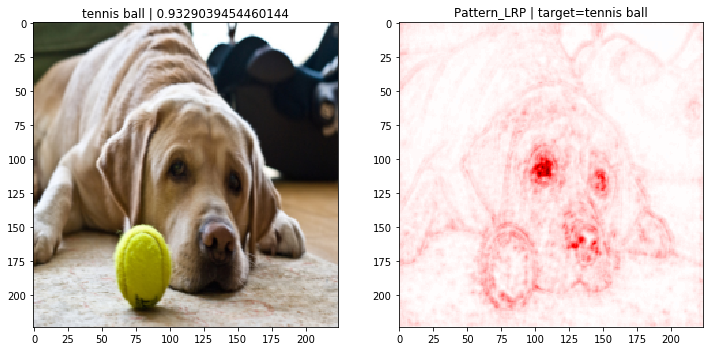

In [12]:
# if target=None, use an output unit with max probability.
# Otherwise, we can use a specific unit, like "target=[class_number]". 

target = 852 ###
one_hot = utils.one_hot(output, target=target) 
Rel = my_vgg.pattern_LRP(one_hot)

hmap = utils.show_heatmap(Rel.data.cpu().numpy()[0])

plt.clf()
fig, axs = plt.subplots(1,2, figsize=(12, 6))
axs[0].imshow(plt_img.numpy().transpose(1,2,0))
axs[0].set_title(image_label_mapping[int(idx[0][0])] + " | " + str(float(prob[0][0])))
axs[1].imshow(hmap.transpose(1,2,0))
axs[1].set_title("Pattern_LRP" + " | target=" + image_label_mapping[target])

Text(0.5,1,'Pattern_LRP | target=Labrador retriever')

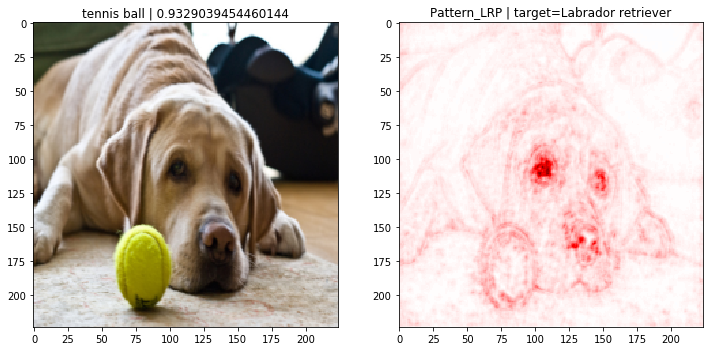

In [13]:
target = 208 ###
one_hot = utils.one_hot(output, target=target) 
Rel = my_vgg.pattern_LRP(one_hot)

hmap = utils.show_heatmap(Rel.data.cpu().numpy()[0])

plt.clf()
fig, axs = plt.subplots(1,2, figsize=(12, 6))
axs[0].imshow(plt_img.numpy().transpose(1,2,0))
axs[0].set_title(image_label_mapping[int(idx[0][0])] + " | " + str(float(prob[0][0])))
axs[1].imshow(hmap.transpose(1,2,0))
axs[1].set_title("Pattern_LRP" + " | target=" + image_label_mapping[target])